# **Using tensorflow framework to training a model for mask detection**

In [33]:
!git clone -b Image_processing https://github.com/labteleunsaac/Proyecto-Covid.git

Cloning into 'Proyecto-Covid'...
remote: Enumerating objects: 7302, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 7302 (delta 8), reused 288 (delta 6), pack-reused 7011
Receiving objects: 100% (7302/7302), 1.33 GiB | 40.45 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Checking out files: 100% (4788/4788), done.


In [1]:
!nvidia-smi

Fri Jun  4 16:26:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import needed libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import resnet, VGG16

In [3]:
# Mount the google drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Checking the directories
!ls /content/gdrive/MyDrive/Laboratorio\ institucional/DATASET/dataset_24_05_2021

test  train


In [5]:
# Set up the dataset image folder 
img_folder = '/content/gdrive/MyDrive/Laboratorio institucional/DATASET/dataset_24_05_2021/train'
test_folder = '/content/gdrive/MyDrive/Laboratorio institucional/DATASET/dataset_24_05_2021/test'

In [6]:
# Set up the trained models folder 
models_folder = '/content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/models'

In [7]:
# Setting up the image dimensions
img_height = 224
img_width = 224

In [8]:
# Setting up some hyperparameters
batch_size = 8
epochs = 50
lr = 0.01

In [9]:
# Splitting the dataset in training group and validation group
train_ds = image_dataset_from_directory(
  img_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1100 files belonging to 2 classes.
Using 880 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  img_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1100 files belonging to 2 classes.
Using 220 files for validation.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 2 classes.


In [12]:
# Showing the class names
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


(8, 224, 224, 3)


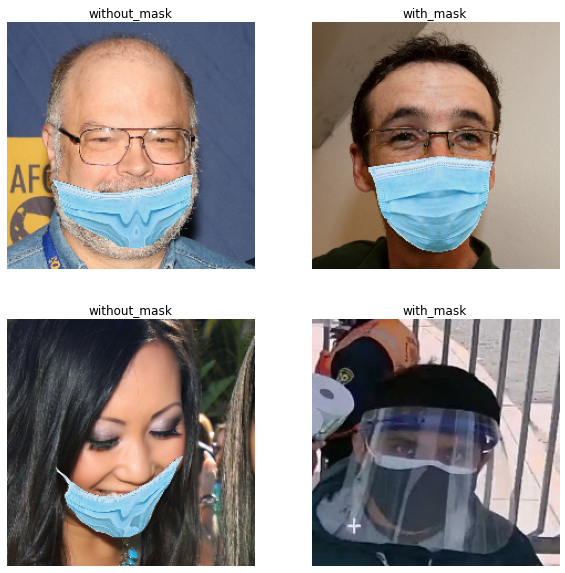

In [13]:
# Taking some images and displaying them
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(images.shape)
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##

In [14]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [16]:
# normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalizedval__ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [17]:
# normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_test_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [18]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Building the model**

In [19]:
def build_model():  
    base_model = VGG16(input_shape=(img_width, img_height, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='max')
    
    base_model.trainable = False

    x = base_model.output
    #x = Dense(100, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [20]:
model_checkpoint = ModelCheckpoint(os.path.join(models_folder,'vgg_{}_{}_{}_tmp.model'.format(batch_size, lr, epochs)), monitor='val_loss',mode = 'min', save_best_only=True, verbose=1, period=1)
earlyStopping = EarlyStopping(monitor='val_loss', mode = 'min',patience=10, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode = 'min',factor=0.001, patience=4, min_lr=0.0000001, verbose=1)

model = build_model()  
opt = tf.keras.optimizers.Adam(lr, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [21]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_checkpoint, earlyStopping]
)

Epoch 1/50
110/110 [==============================] - 16s 104ms/step - loss: 10.2319 - acc: 0.8125 - val_loss: 6.1309 - val_acc: 0.9227

Epoch 00001: val_loss improved from inf to 6.13086, saving model to /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/models/vgg_8_0.01_50_tmp.model
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/models/vgg_8_0.01_50_tmp.model/assets
Epoch 2/50
110/110 [==============================] - 11s 94ms/step - loss: 6.2625 - acc: 0.9000 - val_loss: 11.1793 - val_acc: 0.9000

Epoch 00002: val_loss did not improve from 6.13086
Epoch 3/50
110/110 [==============================] - 10s 91ms/step - loss: 4.4307 - acc: 0.9307 - val_loss: 7.1943 - val_acc: 0.8545

Epoch 00003: val_loss did not improve from 6.13086
Epoch 4/50
110/110 [==============================] - 10s 90ms/step - loss: 2.8673 - acc: 0.9511 - val_loss: 4.2423 - val_acc: 0.8955

Epoch 00004: val_loss improved from 6.13086 to 4.24233, s

In [22]:
len(history.history['acc'])

15

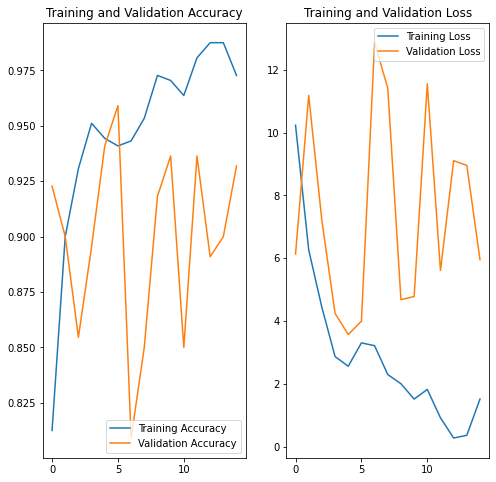

In [23]:
# Showing the learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['acc']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### **Making some predictions**

In [24]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 224, 224, 3)
(8,)


In [25]:
predictions = model.predict(image_batch)

In [26]:
predictions.astype('int')

array([[0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [27]:
labels_batch.numpy()

array([0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

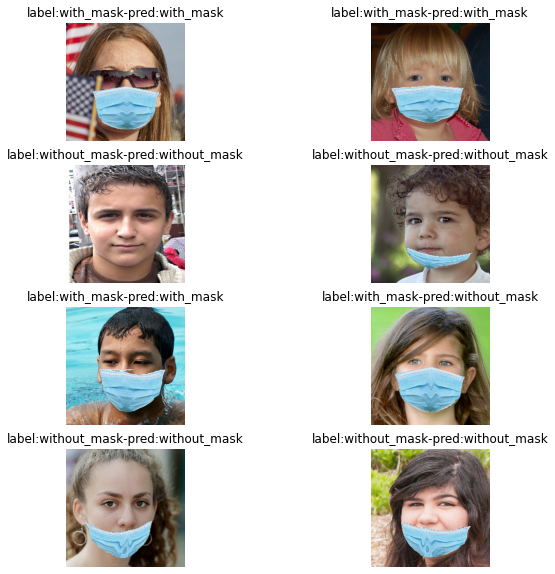

In [28]:
plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='seismic', vmax=1)
    plt.title('label:'+class_names[labels_batch.numpy()[i]]+'-pred:'+class_names[predictions.astype('int')[i][0]])
    plt.axis("off")

### **Evaluating the model**

In [29]:
(loss_test, acc_test) = model.evaluate(test_ds)
(loss_test, acc_test)

19/19 [==============================] - 3s 162ms/step - loss: 24.5975 - acc: 0.8200


(24.59754180908203, 0.8199999928474426)

In [30]:
model_name = 'vgg_{}_{}_{}_{}.h5'.format(batch_size, lr, epochs, round(acc_test, 2))
model_name

'vgg_8_0.01_50_0.82.h5'

In [31]:
model_path = os.path.join(models_folder, model_name)

In [32]:
model.save(model_path)